# INTERNET Notebook

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import optuna
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


In [32]:
df = pd.read_csv('df_train_internet.csv')

In [55]:
print(df.head())
print(df.shape)

   seniorcitizen  partner  dependents  tenure  phoneservice  onlinesecurity  \
0          False    False       False     5.0          True           False   
1          False    False       False    25.0          True            True   
2          False    False       False    42.0          True           False   
3          False    False       False    30.0          True            True   
4          False     True        True    67.0          True           False   

   onlinebackup  deviceprotection  techsupport  streamingtv  ...  churn  \
0         False             False        False         True  ...   True   
1          True              True         True        False  ...  False   
2         False             False         True         True  ...  False   
3          True              True        False        False  ...  False   
4          True              True         True         True  ...  False   

   is_male  internetservice_is_fiber_optic  contract_month-to-month  \
0  

Index(['seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'paperlessbilling', 'monthlycharges',
       'totalcharges', 'churn', 'is_male', 'internetservice_is_fiber_optic',
       'contract_month-to-month', 'contract_one_year', 'contract_two_year',
       'paymentmethod_bank_transfer_(automatic)',
       'paymentmethod_credit_card_(automatic)',
       'paymentmethod_electronic_check', 'paymentmethod_mailed_check'],
      dtype='object')
Correlation with 'Churn':
churn                                      1.000000
contract_month-to-month                    0.387262
paymentmethod_electronic_check             0.262823
internetservice_is_fiber_optic             0.238468
paperlessbilling                           0.141471
seniorcitizen                              0.130574
phoneservice                               0.054693
monthlycharges                     

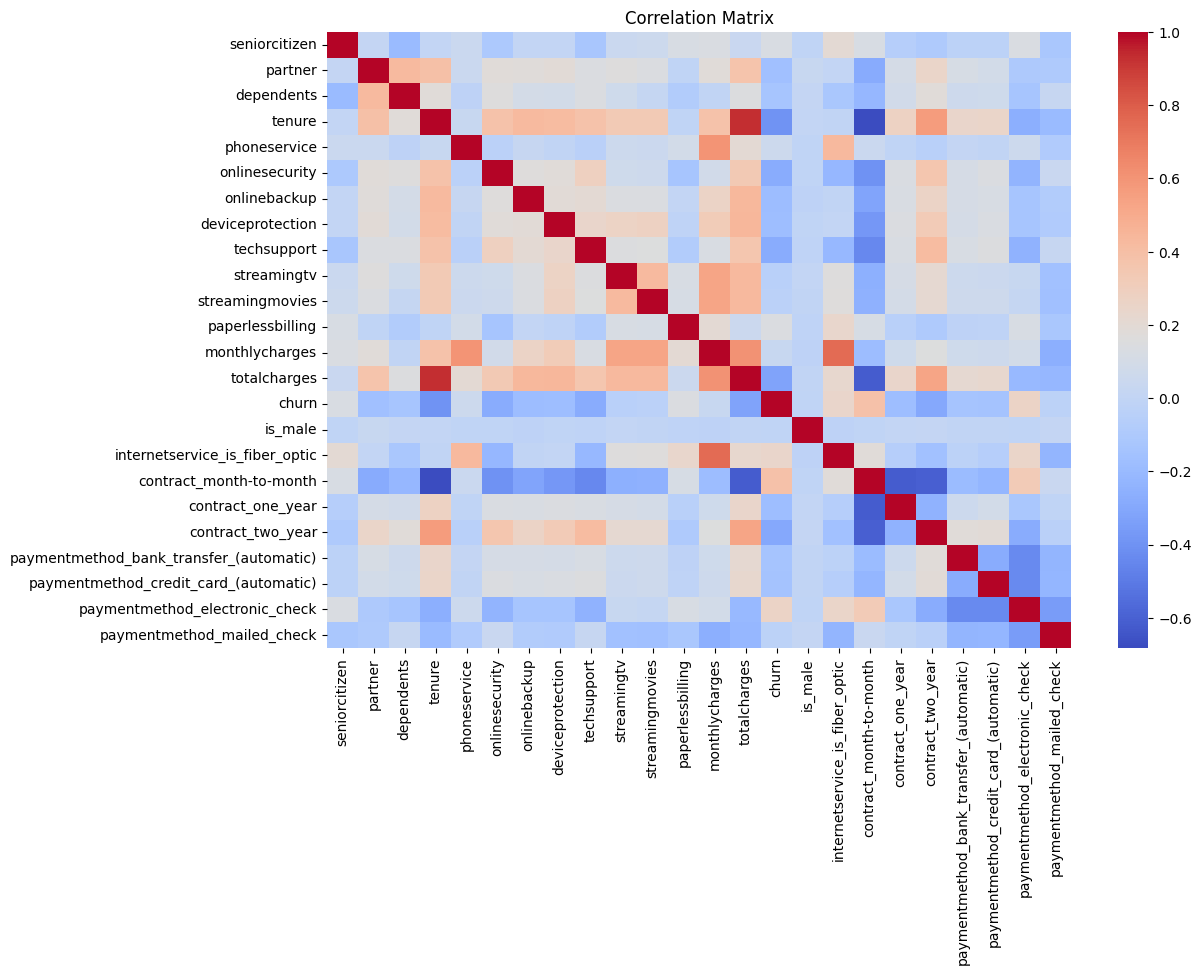

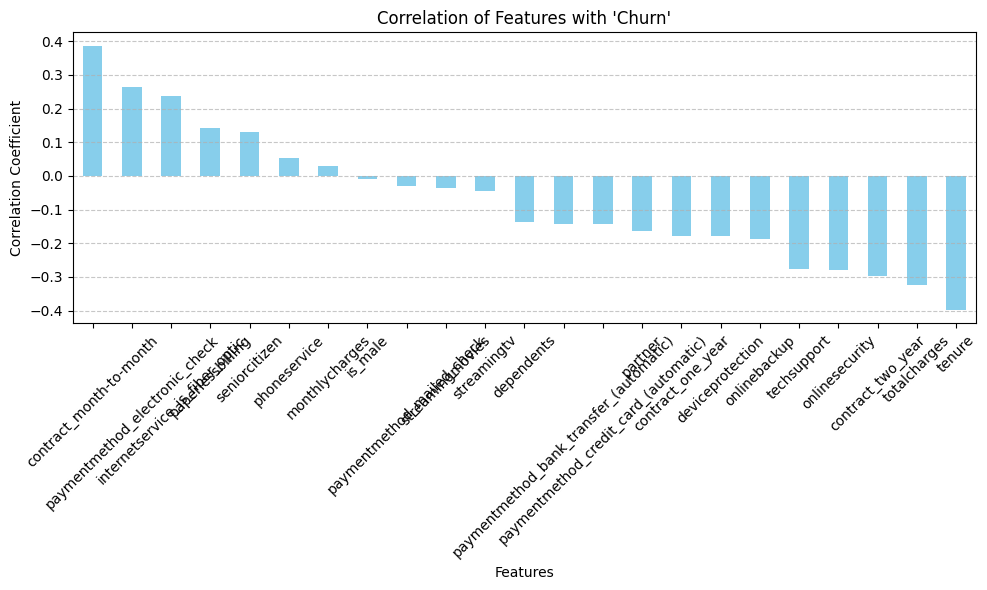

In [71]:
import sys
import os

# Add the parent directory to the system path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

# Import the DataPreprocessor class
from preprocess import DataPreprocessor, DataLoader


import seaborn as sns
import matplotlib.pyplot as plt


# Preprocess categorical columns
data_preprocessor = DataPreprocessor(df)
processed_df = data_preprocessor.preprocess_categorical(df)
print(processed_df.columns)


# Ensure 'Churn' is numeric
processed_df['churn'] = processed_df['churn'].astype(int)

# Compute correlation matrix
correlation_matrix = processed_df.corr()

# Extract correlations with 'Churn'
churn_correlation = correlation_matrix['churn'].sort_values(ascending=False)

# Print correlations
print("Correlation with 'Churn':")
print(churn_correlation)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Plot correlations with 'Churn' as a bar chart
plt.figure(figsize=(10, 6))
churn_correlation.drop('churn').plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with 'Churn'")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [34]:
num_col = ['tenure', 'totalcharges', 'monthlycharges']
target = 'churn'
X_col = [c for c in df.columns if c != target]
cat_col = [c for c in X_col if c not in num_col]


<Axes: xlabel='churn', ylabel='Count'>

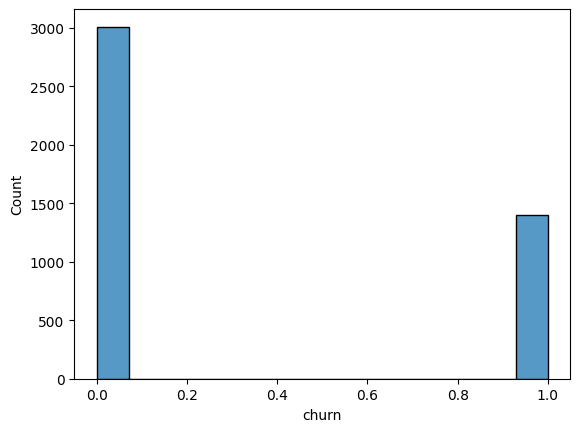

In [35]:
sns.histplot(data=df, x='churn')

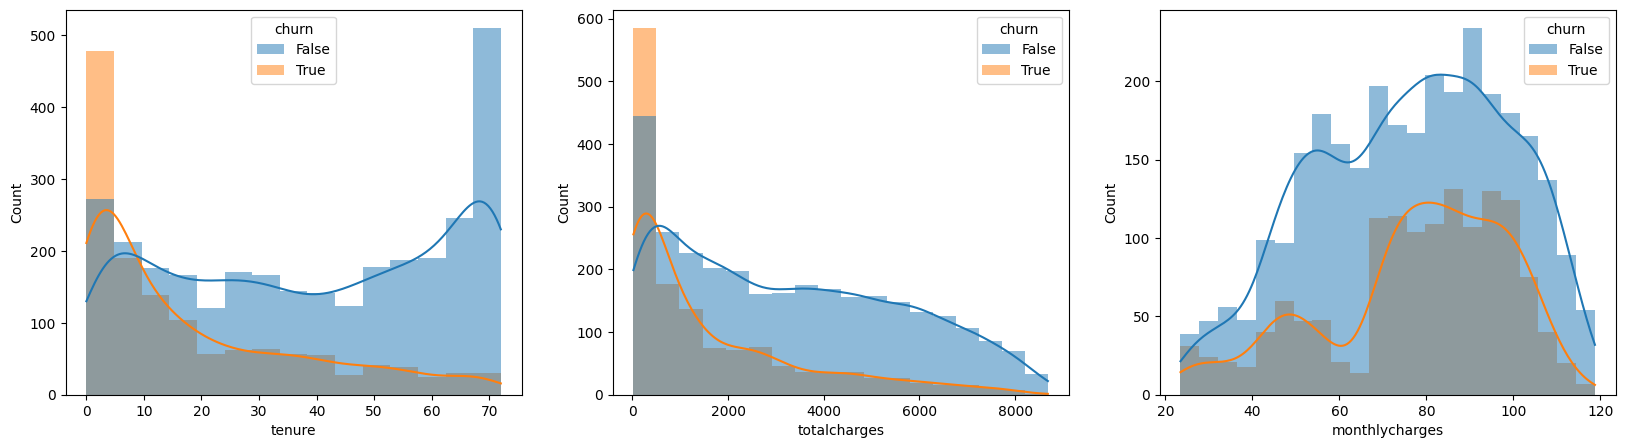

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for col, ax in zip(num_col, axes):
    sns.histplot(
        data=df, x=col, kde=True, ax=ax, hue=target, binwidth=df[col].std() /5, edgecolor=None
    )

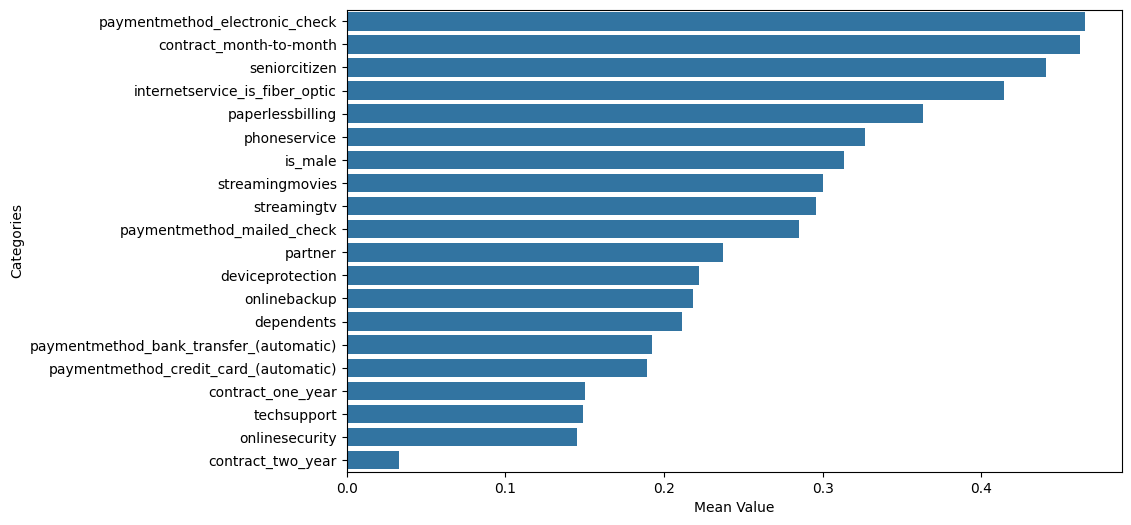

In [37]:
probability_of_churn_given_flag = df[df[target]][cat_col].sum() / df[cat_col].sum()
probability_of_churn_given_flag = probability_of_churn_given_flag.sort_values(ascending = False)

plt.figure(figsize=(10, 6))
sns.barplot(data=probability_of_churn_given_flag, orient= 'h')
plt.xlabel('Mean Value')
plt.ylabel('Categories')
plt.show()

In [38]:
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled.loc[:, num_col] = scaler.fit_transform(df_scaled[num_col])

In [39]:
pca = PCA()
X_pca = pca.fit_transform(df_scaled[X_col])
importances = pca.explained_variance_ratio_ / np.sum(pca.explained_variance_ratio_)
print(pd.Series(importances)[:3])

0    0.266341
1    0.141268
2    0.052790
dtype: float64


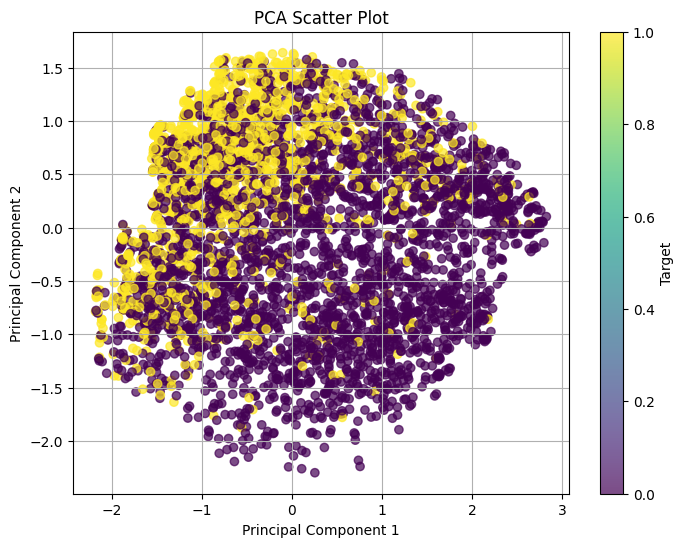

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()


In [41]:
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=df[target],
    labels={"x": "Principal Component 1", "y": "Principal Component 2", "z": "Principal Component 3"},
    title="3D PCA Scatter Plot",
)

fig.update_traces(marker={"size": 3})
fig.update_layout(width=1000, height=800)
fig.show()

In [42]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_scaled[X_col])

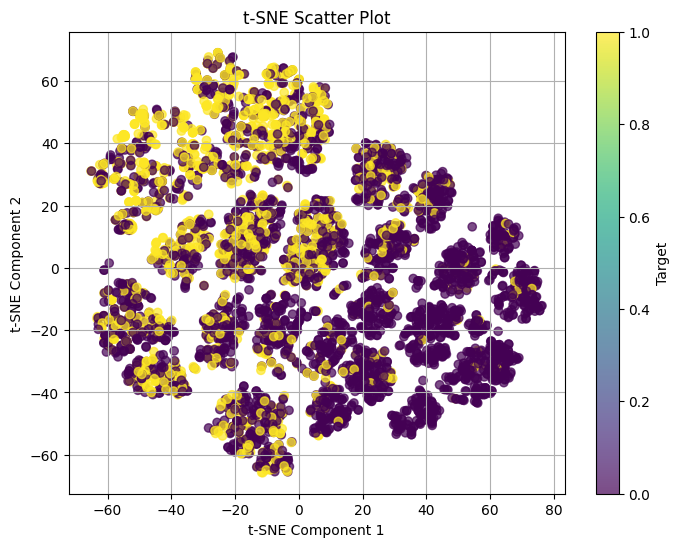

In [43]:

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()

## Modelling

In [44]:
X = df[X_col]
y = df[target]

In [45]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## CatBoost

#### Parameters research

In [46]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 16, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 0, 5),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'loss_function': 'Logloss',
        'eval_metric': 'Accuracy',
        'task_type': 'CPU',
    }

    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
    
        # Create CatBoost Pool
        train_pool = cb.Pool(X_train, y_train)
        valid_pool = cb.Pool(X_valid, y_valid)
        
        # Initialize and train model
        model = cb.CatBoostClassifier(**param, 
                                      verbose=False, 
                                      early_stopping_rounds=15
                                      )
        model.fit(train_pool, 
                  eval_set=valid_pool, 
                  plot=False)
        
        # Predict and calculate accuracy
        preds = model.predict(valid_pool)
        scores.append(roc_auc_score(y_valid, preds))
    
    mean_score = np.mean(scores)
    return mean_score

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42),  pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-11 14:57:13,129] A new study created in memory with name: no-name-92cc0345-6e1c-4fbd-a48d-ab86c719c9bf
[I 2024-12-11 14:57:15,465] Trial 0 finished with value: 0.7304506358169398 and parameters: {'iterations': 687, 'depth': 8, 'learning_rate': 0.07587945476302646, 'l2_leaf_reg': 18.394633936788146, 'subsample': 0.44680559213273097, 'min_data_in_leaf': 0, 'random_strength': 0.21035886311957896}. Best is trial 0 with value: 0.7304506358169398.
[I 2024-12-11 14:57:17,335] Trial 1 finished with value: 0.7168232053655975 and parameters: {'iterations': 933, 'depth': 7, 'learning_rate': 0.0737265320016441, 'l2_leaf_reg': 16.082337977183208, 'subsample': 0.6909729556485982, 'min_data_in_leaf': 4, 'random_strength': 0.5034443102887247}. Best is trial 0 with value: 0.7304506358169398.
[I 2024-12-11 14:57:18,448] Trial 2 finished with value: 0.7039536865217577 and parameters: {'iterations': 591, 'depth': 4, 'learning_rate': 0.0373818018663584, 'l2_leaf_reg': 18.09902572652895, 'subsamp

Best trial: {'iterations': 687, 'depth': 8, 'learning_rate': 0.07587945476302646, 'l2_leaf_reg': 18.394633936788146, 'subsample': 0.44680559213273097, 'min_data_in_leaf': 0, 'random_strength': 0.21035886311957896}


#### Testing

In [47]:
best_params = {'iterations': 862, 'depth': 8, 'learning_rate': 0.09169350952718329, 'l2_leaf_reg': 17.280624018040182, 'subsample': 0.48223683658151323, 'min_data_in_leaf': 5, 'random_strength': 0.4117055183567362}
model = cb.CatBoostClassifier(**best_params, verbose=False)
train_pool = cb.Pool(X, y)
test_pool = cb.Pool(X_test, y_test)
model.fit(train_pool)

In [48]:
print('CatBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

CatBoost scores
Accuracy: 0.7556732223903178
RocAuc: 0.6957886334863634
F1 : 0.5799739921976593


## XGBoost

#### Parameters research

In [49]:
def objective(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        'n_estimators': trial.suggest_int('n_estimators', 800, 1200), 
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-3, 2),
        "alpha": trial.suggest_float("alpha", 1e-3, 2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "eta": trial.suggest_float("eta", 1e-2, 0.3),
        "gamma": trial.suggest_float("gamma", 1e-3, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        "max_bin": trial.suggest_int("max_bin", 64, 255)
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
        model = xgb.XGBClassifier(**param, early_stopping_rounds=15)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        scores.append(accuracy_score(y_valid, preds))
    
    mean_score = np.mean(scores)   
    return mean_score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))
study.optimize(objective, n_trials=20)

print("Best trial:", study.best_trial.params)

[I 2024-12-11 14:58:04,451] A new study created in memory with name: no-name-9da54c3c-4897-4691-9bf3-8a4750c1ce50
[I 2024-12-11 14:58:05,989] Trial 0 finished with value: 0.7205070819148489 and parameters: {'n_estimators': 950, 'booster': 'gbtree', 'lambda': 1.197718309909876, 'alpha': 0.31288126224443064, 'max_depth': 4, 'eta': 0.026844247528777843, 'gamma': 2.5986622611790304, 'min_child_weight': 5, 'subsample': 0.8478254022286159, 'colsample_bytree': 0.6072045730035308, 'grow_policy': 'depthwise', 'max_bin': 104}. Best is trial 0 with value: 0.7205070819148489.
[I 2024-12-11 14:58:12,329] Trial 1 finished with value: 0.769457403437986 and parameters: {'n_estimators': 872, 'booster': 'dart', 'lambda': 1.0499881068328434, 'alpha': 0.8644580922655895, 'max_depth': 5, 'eta': 0.18743733946949004, 'gamma': 0.41934208809547346, 'min_child_weight': 3, 'subsample': 0.7282266451527921, 'colsample_bytree': 0.7596244944759625, 'grow_policy': 'depthwise', 'max_bin': 162}. Best is trial 1 with va

Best trial: {'n_estimators': 872, 'booster': 'dart', 'lambda': 1.0499881068328434, 'alpha': 0.8644580922655895, 'max_depth': 5, 'eta': 0.18743733946949004, 'gamma': 0.41934208809547346, 'min_child_weight': 3, 'subsample': 0.7282266451527921, 'colsample_bytree': 0.7596244944759625, 'grow_policy': 'depthwise', 'max_bin': 162}


#### Testing

In [50]:
best_params = {'n_estimators': 990, 'booster': 'gbtree', 'lambda': 0.6465611069976087, 'alpha': 1.1963315346529115, 'max_depth': 3, 'eta': 0.11623676467831479, 'gamma': 1.6510175761428012, 'min_child_weight': 1, 'subsample': 0.6628472786517728, 'colsample_bytree': 0.874236658152416, 'grow_policy': 'depthwise', 'max_bin': 109}
model = xgb.XGBClassifier(**best_params)
model.fit(X, y)

XGBClassifier(alpha=1.1963315346529115, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.874236658152416, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.11623676467831479, eval_metric=None, feature_types=None,
              gamma=1.6510175761428012, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=0.6465611069976087, learning_rate=None, max_bin=109,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=990, ...)

In [51]:
print('XGBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

XGBoost scores
Accuracy: 0.7602118003025718
RocAuc: 0.6997505001889749
F1 : 0.5856209150326798


## LGBM

#### Parameters research

In [52]:

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 40, 70),
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 70),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 2),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 15),
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_error',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)        
    }
    
    kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
        
        model = lgb.LGBMClassifier(**param, early_stopping_rounds=25, verbose=-1)
        model.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  eval_metric='binary_error')
        
        preds = model.predict(X_valid)
        accuracies.append(accuracy_score(y_valid, preds))
    
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-11 14:59:27,058] A new study created in memory with name: no-name-6f9df820-579d-4756-bcda-b2a2f37a3903
[I 2024-12-11 14:59:28,507] Trial 0 finished with value: 0.7830959363217428 and parameters: {'num_leaves': 51, 'max_depth': 14, 'learning_rate': 0.07587945476302646, 'min_data_in_leaf': 58, 'lambda_l1': 0.39643541684062933, 'lambda_l2': 0.39638958863878504, 'feature_fraction': 0.6203292642588698, 'bagging_fraction': 0.9031616510212273, 'bagging_freq': 11, 'n_estimators': 383}. Best is trial 0 with value: 0.7830959363217428.
[I 2024-12-11 14:59:29,707] Trial 1 finished with value: 0.7840762463343108 and parameters: {'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.08491983767203796, 'min_data_in_leaf': 46, 'lambda_l1': 0.4454674376934912, 'lambda_l2': 0.4484685687215243, 'feature_fraction': 0.7064847850358382, 'bagging_fraction': 0.7836647510712832, 'bagging_freq': 9, 'n_estimators': 216}. Best is trial 1 with value: 0.7840762463343108.
[I 2024-12-11 14:59:30,874] Trial

Best trial: {'num_leaves': 49, 'max_depth': 6, 'learning_rate': 0.09845219997115562, 'min_data_in_leaf': 61, 'lambda_l1': 0.9491610153295127, 'lambda_l2': 1.1885859337107283, 'feature_fraction': 0.8316195751160539, 'bagging_fraction': 0.8495626440300604, 'bagging_freq': 7, 'n_estimators': 426}


#### Testing

In [53]:
best_params = {'num_leaves': 59, 'max_depth': 8, 'learning_rate': 0.09284017157461277, 'min_data_in_leaf': 66, 'lambda_l1': 0.28003957357849574, 'lambda_l2': 0.1829917366656828, 'feature_fraction': 0.7752015772882725, 'bagging_fraction': 0.6682843033321142, 'bagging_freq': 6, 'n_estimators': 186}
model = lgb.LGBMClassifier(**best_params, verbose = -1)
model.fit(X, y)

LGBMClassifier(bagging_fraction=0.6682843033321142, bagging_freq=6,
               feature_fraction=0.7752015772882725,
               lambda_l1=0.28003957357849574, lambda_l2=0.1829917366656828,
               learning_rate=0.09284017157461277, max_depth=8,
               min_data_in_leaf=66, n_estimators=186, num_leaves=59,
               verbose=-1)

In [54]:
print('LGBM scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

LGBM scores
Accuracy: 0.7481089258698941
RocAuc: 0.6876931046604132
F1 : 0.5680933852140078
